In [1]:
import os

vin = 'dataset/out.mp4'
out_dir = 'results/'


In [2]:
from feature_extraction import PatchFeatureGenerator   
    
pfg = PatchFeatureGenerator('dinov2_vitb14')
patch_size = pfg.model.patch_size

Using cache found in /Users/raiso/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


Device:  mps


In [3]:
from video_processing import VideoManager

kernel_frame_size = 16
vm = VideoManager(vin, out_dir, kernel_frame_size)

Video: dataset/out.mp4 (80 fps)
Extracting frames to results/frame/
already prepare images


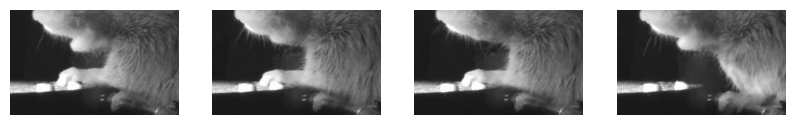

In [4]:
from matplotlib import pyplot as plt

kernel_frame = vm.getkernelframe()
plt.figure(figsize=(10, 8))
for i in range(4):
    it = kernel_frame[i]
    plt.subplot(1, 4, i+1)
    plt.imshow(it)
    plt.axis('off')
plt.show()
plt.close()

In [5]:
# transform

import torchvision.transforms as tt
resolution = 518
patch_len = resolution // 14

img2tensor = tt.Compose([
    tt.ToTensor(), # range [0, 255] -> [0.0,1.0]
    tt.Resize((resolution, resolution) ),
    tt.Normalize(mean=0.5, std=0.2), # range [0.0,1.0] -> [-2.5, 2.5]

])

tensor2img = tt.Compose([
    tt.Normalize(mean=-2.5, std=5), # range [-2.5, 2.5] -> [0.0,1.0]
    tt.ToPILImage()
])

In [6]:
from feature_extraction import FeatureFilter
import numpy as np


kernel_frame = vm.getkernelframe()
kernel_tensor = [img2tensor(it) for it in kernel_frame]
patch_feature = pfg.batch_run(kernel_tensor)
print(patch_feature.shape)

/Users/raiso/BLFV-GUI/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(16, 1369, 768)


In [ ]:
# from sklearn.manifold import TSNE


# def tsneView(X):
#     tsne = TSNE(n_components=2, random_state=42)
#     # 對數據進行降維
#     X_tsne = tsne.fit_transform(X)

#     # 繪製降維結果
#     plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
#     plt.show()
#     plt.close()
#     return

In [ ]:


# # 載入你的高維數據

# X = np.array(patch_feature[0])
# n_token_per_frame, n_feat = X.shape
# print(n_token_per_frame, n_feat)
# X = X.reshape((-1, n_feat))
# print(X.shape)

# tsneView(X)



In [112]:
import cv2
X = np.array(patch_feature)
n_kernel, n_token_per_frame, n_feat = X.shape
kernel_size = (3, 3)
sigma = 1.

# blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)
for i, it in enumerate(X):
    jt = it.reshape((patch_len, patch_len, -1))
    for j in range(n_feat):
        blurred_image = cv2.GaussianBlur(jt[:, :, j], kernel_size, sigma)
        X[i, :, j] = blurred_image.reshape((-1))

print(n_kernel, n_token_per_frame, n_feat)
X = X.reshape((-1, n_feat))
print(X.shape)

16 1369 768
(21904, 768)


In [113]:
jt.shape

(37, 37, 768)

In [114]:
ff = FeatureFilter()


(21904,) (21904, 1)


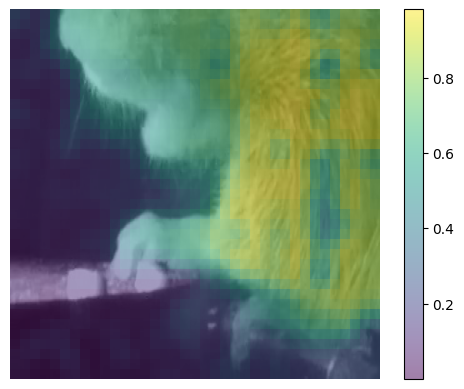

In [115]:
lvl1_pca = 1
ff.addLayer(X, lvl1_pca)
mm, zz = ff.getFeature(X)
print(mm.shape, zz.shape)
frames_feat = np.zeros((n_kernel * n_token_per_frame, lvl1_pca))
frames_feat[mm] = zz
frames_feat = frames_feat.reshape((n_kernel, n_token_per_frame))
kernel_frame = vm.getkernelframe()
plt.imshow(kernel_frame[0], extent=(0, resolution, resolution,0))
plt.imshow(frames_feat[0].reshape((patch_len, patch_len, lvl1_pca)), extent=(0, resolution, resolution,0), alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()
plt.close()

(21904,) (3632, 1)


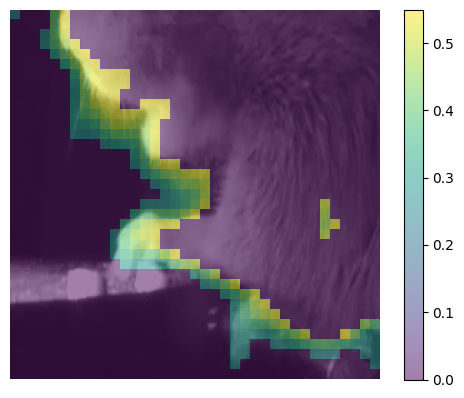

In [116]:
ff.setLayerThreshold(0, [(.25, .55)])
mm, zz = ff.getFeature(X)
print(mm.shape, zz.shape)
frames_feat = np.zeros((n_kernel * n_token_per_frame, lvl1_pca))
frames_feat[mm] = zz
frames_feat = frames_feat.reshape((n_kernel, n_token_per_frame, lvl1_pca))
kernel_frame = vm.getkernelframe()
plt.imshow(kernel_frame[0], extent=(0, resolution, resolution,0))
plt.imshow(frames_feat[0].reshape((patch_len, patch_len, lvl1_pca)), extent=(0, resolution, resolution,0), alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()
plt.close()

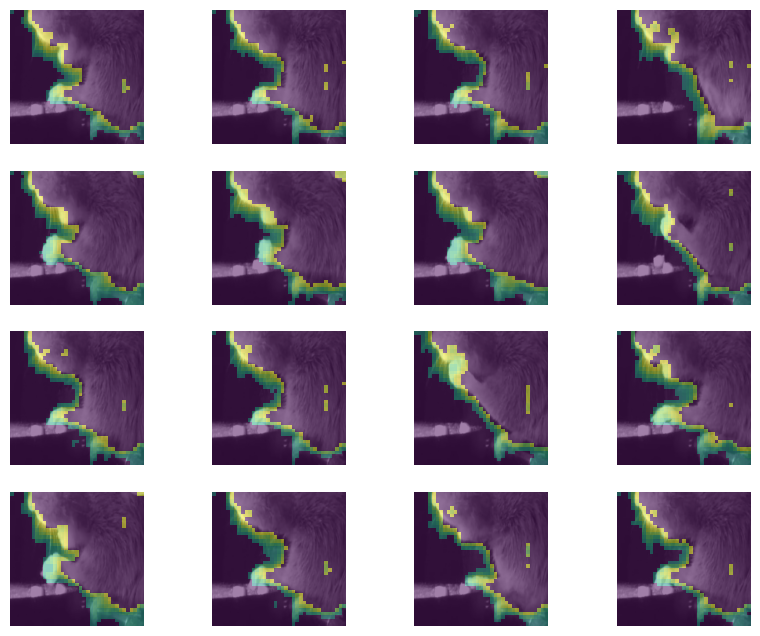

In [117]:
plt.figure(figsize=(10, 8))
for i, _ in enumerate(kernel_frame):
    plt.subplot(4, 4, i+1)
    plt.imshow(kernel_frame[i], extent=(0, resolution, resolution,0))
    plt.imshow(frames_feat[i].reshape((patch_len, patch_len, lvl1_pca)), extent=(0, resolution, resolution,0), alpha=0.5)

    plt.axis('off')
plt.show()
plt.close()

(21904,) (3632, 3)


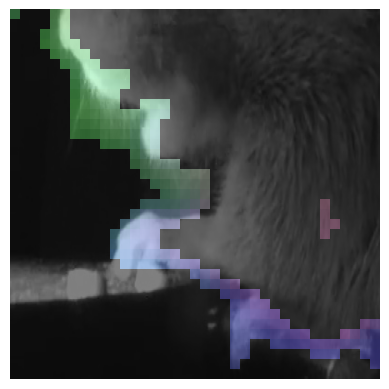

In [118]:
lvl2_pca = 3
ff.addLayer(X, lvl2_pca)
mm, zz = ff.getFeature(X)
print(mm.shape, zz.shape)
frames_feat = np.zeros((n_kernel * n_token_per_frame, lvl2_pca))
frames_feat[mm] = zz
frames_feat = frames_feat.reshape((n_kernel, n_token_per_frame, lvl2_pca))
kernel_frame = vm.getkernelframe()
plt.imshow(kernel_frame[0], extent=(0, resolution, resolution,0))
plt.imshow(frames_feat[0].reshape((patch_len, patch_len, lvl2_pca)), extent=(0, resolution, resolution,0), alpha=0.5)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
# tsne = TSNE(n_components=2, random_state=42)
# XX = X[mm]
# X_tsne = tsne.fit_transform(XX)

# # 繪製降維結果
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=zz)
# plt.show()
# plt.close()


(21904,) (582, 3)


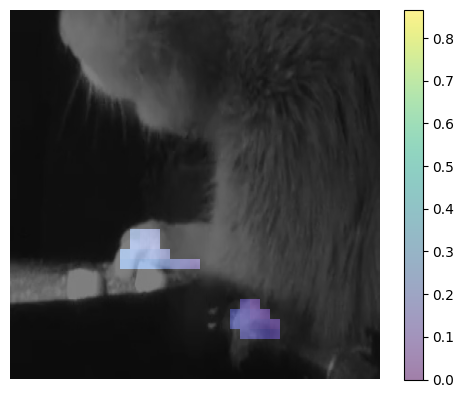

In [120]:
ff.setLayerThreshold(1, [(.0, 1.), (.0, 1.), (.8, 1.)])
mm, zz = ff.getFeature(X)
print(mm.shape, zz.shape)
frames_feat = np.zeros((n_kernel * n_token_per_frame, lvl2_pca))
frames_feat[mm] = zz
frames_feat = frames_feat.reshape((n_kernel, n_token_per_frame, lvl2_pca))
kernel_frame = vm.getkernelframe()
plt.imshow(kernel_frame[1], extent=(0, resolution, resolution,0))
plt.imshow(frames_feat[1].reshape((patch_len, patch_len, lvl2_pca)), extent=(0, resolution, resolution,0), alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()
plt.close()

In [ ]:
# tsne = TSNE(n_components=2, random_state=42)
# XX = X[mm]
# X_tsne = tsne.fit_transform(XX)

# # 繪製降維結果
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=zz)
# plt.show()
# plt.close()


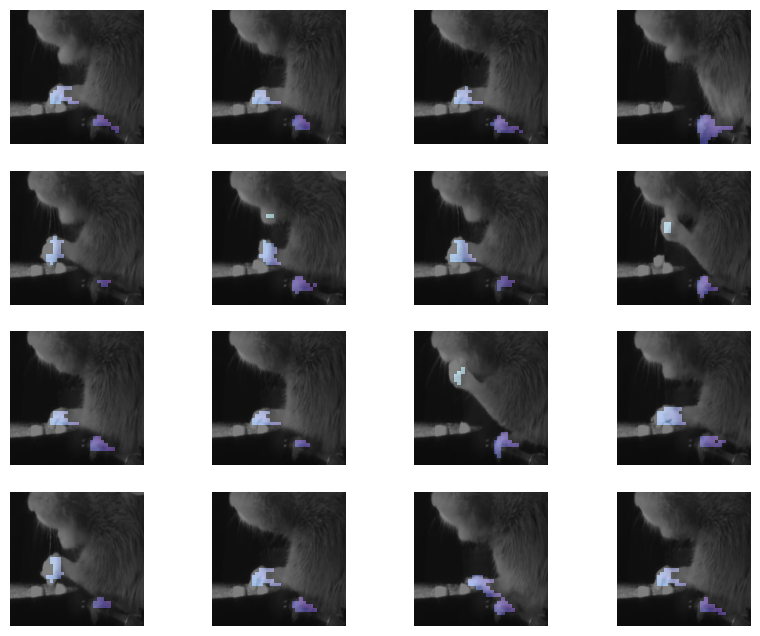

In [121]:
plt.figure(figsize=(10, 8))
for i, _ in enumerate(kernel_frame):
    plt.subplot(4, 4, i+1)
    plt.imshow(kernel_frame[i], extent=(0, resolution, resolution,0))
    plt.imshow(frames_feat[i].reshape((patch_len, patch_len, lvl2_pca)), extent=(0, resolution, resolution,0), alpha=0.5)

    plt.axis('off')
plt.show()
plt.close()

(21904,) (582, 1)


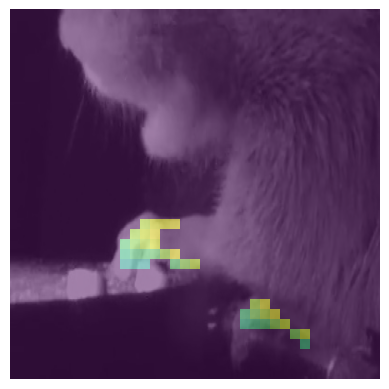

In [122]:
lvl3_pca = 1
ff.addLayer(X, lvl3_pca)
mm, zz = ff.getFeature(X)
print(mm.shape, zz.shape)
frames_feat = np.zeros((n_kernel * n_token_per_frame, lvl3_pca))
frames_feat[mm] = zz
frames_feat = frames_feat.reshape((n_kernel, n_token_per_frame, lvl3_pca))
kernel_frame = vm.getkernelframe()
plt.imshow(kernel_frame[0], extent=(0, resolution, resolution,0))
plt.imshow(frames_feat[0].reshape((patch_len, patch_len, lvl3_pca)), extent=(0, resolution, resolution,0), alpha=0.5)
plt.axis('off')
plt.show()
plt.close()

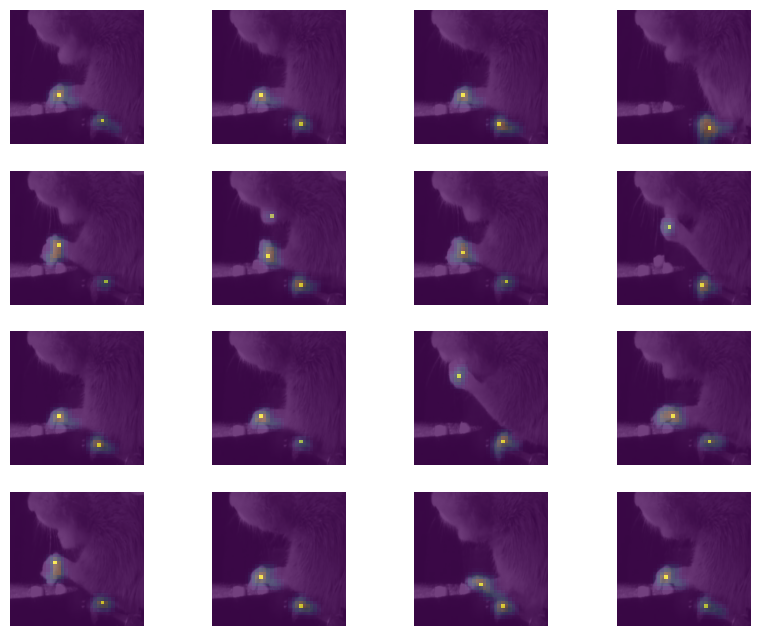

In [124]:
import cv2
# 定義高斯核的大小和標準差
kernel_size = (5, 5)
sigma = 1.

# 進行高斯模糊處理
# blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)


plt.figure(figsize=(10, 8))
for i, _ in enumerate(kernel_frame):
    plt.subplot(4, 4, i+1)
    plt.imshow(kernel_frame[i], extent=(0, resolution, resolution,0))
    # plt.imshow(frames_feat[i].reshape((patch_len, patch_len, lvl3_pca)), extent=(0, resolution, resolution,0), alpha=0.5)
    
    image = frames_feat[i].reshape((patch_len, patch_len, lvl3_pca)) * 255
    blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)
    plt.imshow(blurred_image, extent=(0, resolution, resolution,0), alpha=0.5)
    dilated_image = cv2.dilate(blurred_image, np.ones((5, 5), np.uint8))
    local_maxima = cv2.compare(blurred_image, dilated_image, cv2.CMP_EQ)
    local_maxima[blurred_image == 0] = 0
    local_maxima = local_maxima.astype(np.uint8) * 255
    plt.imshow(local_maxima, extent=(0, resolution, resolution,0), alpha=0.5)
    plt.axis('off')
plt.show()
plt.close()

In [ ]:
# ff.setLayerThreshold(2, [(.35, .55)])
# mm, zz = ff.getFeature(X)
# print(mm.shape, zz.shape)
# frames_feat = np.zeros((n_kernel * n_token_per_frame, lvl3_pca))
# frames_feat[mm] = zz
# frames_feat = frames_feat.reshape((n_kernel, n_token_per_frame, lvl3_pca))
# kernel_frame = vm.getkernelframe()
# plt.imshow(kernel_frame[0], extent=(0, resolution, resolution,0))
# plt.imshow(frames_feat[0].reshape((patch_len, patch_len, lvl3_pca)), extent=(0, resolution, resolution,0), alpha=0.5)
# plt.axis('off')
# plt.colorbar()
# plt.show()
# plt.close()

In [ ]:
# lvl4_pca = 5
# ff.addLayer(X, lvl4_pca)

In [ ]:
# ff.setLayerThreshold(3, [(.0, 1.), (.0, 1.), (.0, 1.), (.0, 1.), (.0, 1.)])
# mm, zz = ff.getFeature(X)
# print(mm.shape, zz.shape)
# frames_feat = np.zeros((n_kernel * n_token_per_frame, lvl4_pca))
# frames_feat[mm] = zz
# frames_feat = frames_feat.reshape((n_kernel, n_token_per_frame, lvl4_pca))
# kernel_frame = vm.getkernelframe()
# plt.imshow(kernel_frame[0], extent=(0, resolution, resolution,0))
# plt.imshow(frames_feat[0].reshape((patch_len, patch_len, lvl4_pca))[:, :, 3], extent=(0, resolution, resolution,0), alpha=0.5)
# plt.axis('off')
# plt.colorbar()
# plt.show()
# plt.close()

In [ ]:
# plt.figure(figsize=(10, 8))
# for i, _ in enumerate(kernel_frame):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(kernel_frame[i], extent=(0, resolution, resolution,0))
#     plt.imshow(frames_feat[i].reshape((patch_len, patch_len, lvl4_pca))[:, :, 3], extent=(0, resolution, resolution,0), alpha=0.5)

#     plt.axis('off')
# plt.show()
# plt.close()

In [125]:
import glob
import os
from tqdm import tqdm

class Watcher:
    def __init__(self, videoManager, patchFeatureGenerator, featureFilter, export):
        self.frames = videoManager
        self.pfg = patchFeatureGenerator
        self.ff = featureFilter
        self.export = export
        self.attn_dir = export + 'attn/'
        self.num_features = self.pfg.model.num_features
    def run(self):
        os.makedirs(self.export, exist_ok=True)
        os.makedirs(self.attn_dir, exist_ok=True)
        last_dim_pca = self.ff.blk[-1].n_pca
        sigma = 1
        # for i in tqdm(range(len(self.frames.full_frame))):
        for i in tqdm(range(100)):
            frame = self.frames.getframe(i)
            tensor = img2tensor(frame)
            patch_feature = self.pfg.single_run(tensor)
            X = patch_feature.reshape((-1, self.num_features))
            mm, zz = self.ff.getFeature(X)
            assert len(self.ff.blk) != 0, "no filter in featureFilter."
            
            last_dim_pca = self.ff.blk[-1].n_pca
            frames_feat = np.zeros((n_token_per_frame, last_dim_pca))
            frames_feat[mm] = zz
            plt.imshow(frame, extent=(0, resolution, resolution, 0))
            # plt.imshow(frames_feat.reshape((patch_len, patch_len, last_dim_pca))[:, :, :], extent=(0, resolution, resolution,0), alpha=0.3, cmap="inferno")
            image = frames_feat.reshape((patch_len, patch_len, last_dim_pca)) 
            image[image > 0.1] = 1
            blurred_image = cv2.GaussianBlur(image, (5, 5), sigma)
            plt.imshow(blurred_image, extent=(0, resolution, resolution,0), alpha=0.5,cmap="inferno")
            dilated_image = cv2.dilate(blurred_image, np.ones((5, 5), np.uint8))
            local_maxima = cv2.compare(blurred_image, dilated_image, cv2.CMP_EQ)
            local_maxima[blurred_image < 0.35] = 0
            # print(blurred_image[blurred_image > 0.7])
            local_maxima = local_maxima.astype(np.uint8)
            plt.imshow(local_maxima, extent=(0, resolution, resolution,0), alpha=0.5, cmap="inferno")

            plt.axis('off')
            # plt.show()
            # assert 0
            plt.savefig(self.attn_dir + 'attn-{:04d}.jpg'.format(i), bbox_inches='tight')
            plt.close()



wa = Watcher(vm, pfg, ff, out_dir)
wa.run()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/raiso/BLFV-GUI/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/100 [00:01<01:49,  1.10s/it]/Users/raiso/BLFV-GUI/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing tran

In [126]:
import cv2
from PIL import Image
video_format = 'mp4'
fps = 24

FOURCC = {
    "mp4": cv2.VideoWriter_fourcc(*"h264"),
    "avi": cv2.VideoWriter_fourcc(*"XVID"),
}


def generate_video_from_images(inp: str, out: str):
    img_array = []
    attention_images_list = sorted(glob.glob(os.path.join(inp, "*.jpg")))

    # Get size of the first image
    with open(attention_images_list[0], "rb") as f:
        img = Image.open(f)
        img = img.convert("RGB")
        size = (img.width, img.height)


    print(f"Generating video {size} to {out}")

    for filename in tqdm(attention_images_list):
        with open(filename, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            img_array.append(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))

    out = cv2.VideoWriter(
        os.path.join(out, "video." + video_format),
        FOURCC[video_format],
        fps,
        size,
    )

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    print("Done")

generate_video_from_images(wa.attn_dir, out_dir)

Generating video (389, 389) to results/


100%|██████████| 100/100 [00:00<00:00, 680.63it/s]
OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


Done
